In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image_dataset_from_directory
import glob
import pandas as pd
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

C:\Users\User\anaconda3\envs\gpu_env\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [ ]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
list_path = []
list_labels = []
DATA_PATHS = ["cecilia_direita_landmarks", "cecilia_esquerda_landmarks","dani_direita_landmarks","dani_esquerda_landmarks","iamato_direita_landmarks","iamato_esquerda_landmarks", "odonto_direita_landmarks", "odonto_esquerda_landmarks", "viguini_esquerda_landmarks", "viguini_direita_landmarks"] 
TEST_PATHS = ["cecilia_direita_landmarks", "cecilia_esquerda_landmarks"]

for path in DATA_PATHS:
    if path not in TEST_PATHS:
        for label in labels:
            label_path = os.path.join(path, label, "*")
            image_files = glob.glob(label_path)
            
            sign_label = [label] * len(image_files)
            
            list_path.extend(image_files)
            list_labels.extend(sign_label)

data_train = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

list_path = []
list_labels = []

for test_path in TEST_PATHS:
    for label in labels:
        label_path = os.path.join(test_path, label, "*")
        image_files = glob.glob(label_path)
        
        sign_label = [label] * len(image_files)
        
        list_path.extend(image_files)
        list_labels.extend(sign_label)

data_val = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

In [14]:
data_train['label'].value_counts()

label
L    3538
I    3512
G    3419
O    3366
E    3354
F    3354
K    3324
M    3288
A    3246
N    3234
X    3223
U    3211
W    3195
Q    3194
T    3188
Y    3158
D    3150
P    3145
C    3140
R    3106
V    3084
H    3065
B    2906
S    2831
Name: count, dtype: int64

In [15]:
label_to_index = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6,
    'H': 7,
    'I': 8,
    'K': 9,
    'L': 10,
    'M': 11,
    'N': 12,
    'O': 13,
    'P': 14,
    'Q': 15,
    'R': 16,
    'S': 17,
    'T': 18,
    'U': 19,
    'V': 20,
    'W': 21,
    'X': 22,
    'Y': 23
}

data_train['label'] = data_train['label'].map(label_to_index)
data_val['label'] = data_val['label'].map(label_to_index)

In [17]:
data_val.head(10)

,image_path,label
0,padronizado/cecilia_direita_landmarks\A\sinal_...,0
1,padronizado/cecilia_direita_landmarks\A\sinal_...,0
2,padronizado/cecilia_direita_landmarks\A\sinal_...,0
3,padronizado/cecilia_direita_landmarks\A\sinal_...,0
4,padronizado/cecilia_direita_landmarks\A\sinal_...,0
5,padronizado/cecilia_direita_landmarks\A\sinal_...,0
6,padronizado/cecilia_direita_landmarks\A\sinal_...,0
7,padronizado/cecilia_direita_landmarks\A\sinal_...,0
8,padronizado/cecilia_direita_landmarks\A\sinal_...,0
9,padronizado/cecilia_direita_landmarks\A\sinal_...,0


In [18]:
train_ds = tf.data.Dataset.from_tensor_slices((data_train['image_path'].values, data_train['label'].values))
val_ds = tf.data.Dataset.from_tensor_slices((data_val['image_path'].values, data_val['label'].values))

In [19]:
from tensorflow.keras.applications.mobilenet import preprocess_input

IMG_SIZE = (224, 224)

def process_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)
    return image, label

In [20]:
BATCH_SIZE = 32
train_ds = train_ds.map(process_image)
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE)
val_ds = val_ds.map(process_image)
val_ds = val_ds.batch(BATCH_SIZE)

In [21]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [23]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models

num_classes = data_train['label'].nunique()

base_model = MobileNet(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
EPOCHS = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/5
2414/2414 [==============================] - 253s 97ms/step - loss: 3.2254 - accuracy: 0.9532 - val_loss: 34.0832 - val_accuracy: 0.6650
Epoch 2/5
2414/2414 [==============================] - 224s 92ms/step - loss: 0.6257 - accuracy: 0.9915 - val_loss: 26.6928 - val_accuracy: 0.6806
Epoch 3/5
2414/2414 [==============================] - 221s 91ms/step - loss: 0.2593 - accuracy: 0.9949 - val_loss: 27.2060 - val_accuracy: 0.6819
Epoch 4/5
2414/2414 [==============================] - 211s 87ms/step - loss: 0.2166 - accuracy: 0.9958 - val_loss: 31.9259 - val_accuracy: 0.6873
Epoch 5/5
2414/2414 [==============================] - 204s 84ms/step - loss: 0.1226 - accuracy: 0.9975 - val_loss: 24.7896 - val_accuracy: 0.7394


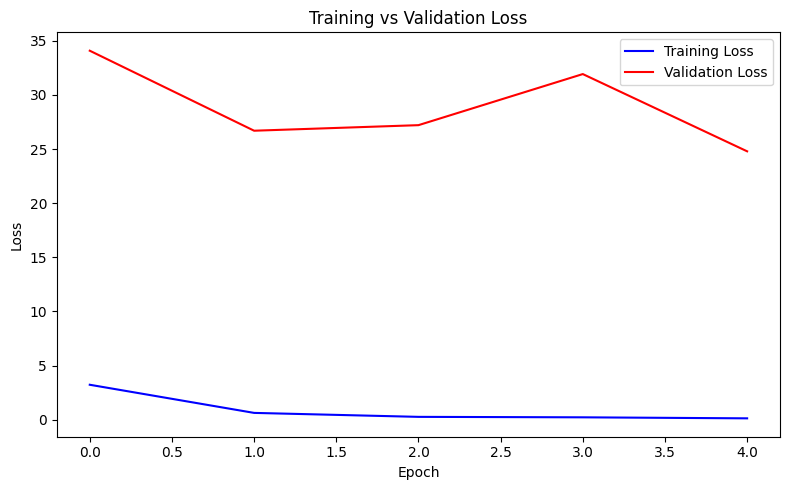

In [25]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(EPOCHS)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

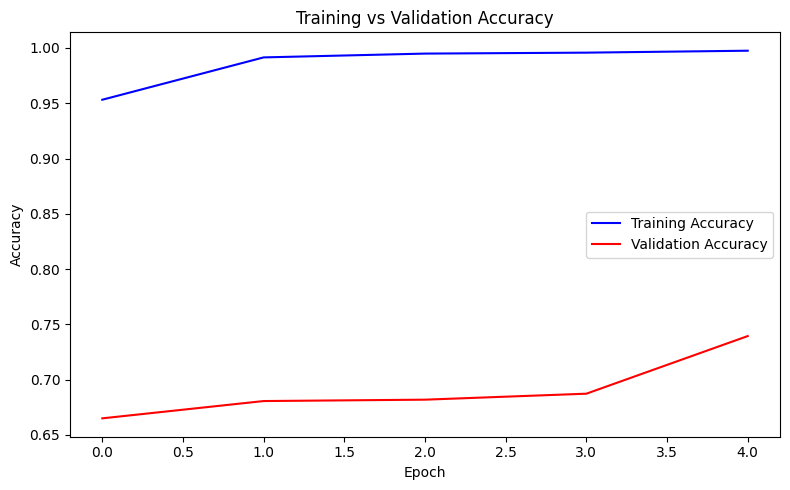

In [26]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd

# === Parameters ===
image_size = (224, 224)  # MobileNet expects 224x224
batch_size = 32
test_dir = TEST_PATHS[0]

# === Data Generator ===
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# === Predict ===
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# === Confusion Matrix & Accuracy ===
cm = confusion_matrix(true_classes, predicted_classes)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
total_accuracy = accuracy_score(true_classes, predicted_classes)

# === Print Results ===
df_accuracy = pd.DataFrame({
    'Class': class_labels,
    'Accuracy': per_class_accuracy
})

print("Per-class Accuracy:\n")
print(df_accuracy)
print(f"\nTotal Accuracy: {total_accuracy:.4f}")


Found 1331 images belonging to 24 classes.
42/42 [==============================] - 2s 37ms/step
Per-class Accuracy:

   Class  Accuracy
0      A  0.019231
1      B  1.000000
2      C  1.000000
3      D  0.338462
4      E  0.928571
5      F  1.000000
6      G  1.000000
7      H  1.000000
8      I  0.611111
9      K  0.928571
10     L  0.943396
11     M  0.812500
12     N  0.000000
13     O  0.441860
14     P  0.000000
15     Q  1.000000
16     R  1.000000
17     S  0.470588
18     T  0.033333
19     U  0.980000
20     V  0.800000
21     W  0.765957
22     X  1.000000
23     Y  0.919355

Total Accuracy: 0.7160


In [33]:
model.save('models/mobilenet_padronizado.h5')

In [32]:
model.save("mobilenet_converted.keras", save_format="keras_v3")